In [282]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [283]:
data = pd.read_table(
        "../Data/sun_10years_beijing.txt", # "sun_10years_beijing.txt" for sun, "moon_10years_beijing.txt" for moon
        names=['Time', 'Solar', 'Lunar' , 'R.A.', 'DEC',  'dRA*cosD', 'd(DEC)',  'T-O-M', 'MN_Illu%'],
        delimiter=',',
        index_col=False,
        skiprows = 62,
        skipfooter = 81,
        engine='python'
)
data['Hours'] = pd.to_datetime(moon['Time']).astype(int) / 3600 / 10**9 - \
                pd.to_datetime(['2009-01-01 00:00']).astype(int) / 3600 /10**9

In [284]:
data.head()

,Time,Solar,Lunar,R.A.,DEC,dRA*cosD,d(DEC),T-O-M,MN_Illu%,Hours
0,2009-Jan-01 01:00,*,,281.55074,-23.01542,151.2570,11.78931,50.0,17.9427,0.0
1,2009-Jan-01 02:00,*,,281.59635,-23.01216,150.9390,11.97354,50.5,18.2553,1.0
2,2009-Jan-01 03:00,*,m,281.64186,-23.00885,150.7219,12.18478,50.9,18.5419,2.0
3,2009-Jan-01 04:00,*,m,281.68734,-23.00547,150.6203,12.41190,51.3,18.8039,3.0
4,2009-Jan-01 05:00,*,m,281.73279,-23.00203,150.6408,12.64267,51.6,19.0444,4.0


In [285]:
data.tail()

,Time,Solar,Lunar,R.A.,DEC,dRA*cosD,d(DEC),T-O-M,MN_Illu%,Hours
87642,2018-Dec-31 19:00,,m,280.65095,-23.07633,153.8402,11.06780,59.6,24.8204,87642.0
87643,2018-Dec-31 20:00,,m,280.69736,-23.07335,153.4879,10.99324,59.2,24.4792,87643.0
87644,2018-Dec-31 21:00,,m,280.74365,-23.07038,153.0663,10.95826,58.8,24.1702,87644.0
87645,2018-Dec-31 22:00,A,m,280.78980,-23.06742,152.6040,10.96850,58.4,23.8892,87645.0
87646,2018-Dec-31 23:00,N,m,280.83581,-23.06445,152.1323,11.02653,58.0,23.6302,87646.0


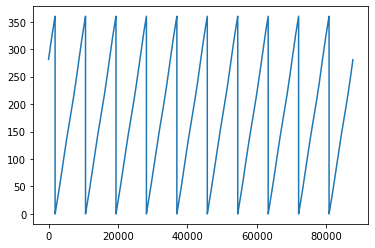

In [286]:
plt.plot(data['R.A.'])

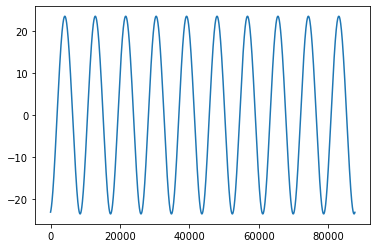

In [287]:
plt.plot(data['DEC'])

In [288]:
N = len(data)

# use the below two rows for moon data
# N_train = int(N*0.6//(27.321582*24) * 27.321582*24)
# N_validation = int(N*0.8//(27.321582*24) * 27.321582*24) - N_train

# use the below two rows for sun data
N_train = int(N*0.6)
N_validation = int(N*0.8) - N_train

N_test = N - N_train - N_validation
data_train = data[:N_train]
data_validation = data[N_train:(N_train + N_validation)]
data_test = data[(N_train + N_validation):]

In [289]:
# n_harm: number of harmonics in model
def fourierExtrapolation(x, n_predict, n_harm=6):
    n = x.size                  
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = np.fft.fft(x_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies
    #plt.ylabel("Amplitude")
    #plt.xlabel("Frequency [Hz]")
    #plt.plot(f[:n // 10], np.abs(x_freqdom)[:n // 10]*1 / n)  # 1 / N is a normalization factor
    #plt.show()
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    #indexes.sort(key = lambda i: np.absolute(f[i]))
    indexes.sort(key=lambda i: np.absolute(x_freqdom[i]))
    indexes.reverse()
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(n + n_predict)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

In [290]:
def tune_n_harm(col, n_harm_range):
    loss = []
    for n_harm in n_harm_range:
        restored_sig = fourierExtrapolation(data_train[col], N_validation, n_harm)
        loss.append(np.mean((data_validation[col]- restored_sig[-N_validation:]))**2)
    plt.ylabel("validation error")
    plt.xlabel("number of selected frequencies")
    plt.plot(n_harm_range, loss) 
    return loss

n_harm for RA: 4


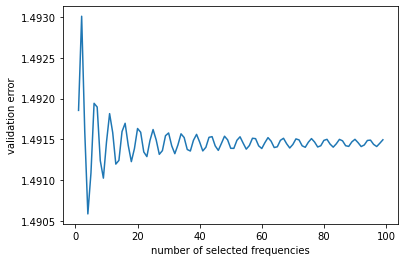

In [292]:
RA_loss = tune_n_harm('R.A.', [i for i in range(1, 100) ])
print("n_harm for RA:", np.argmin(RA_loss)+1)

train_error: 2.2609710261958713e-27
validation_error: 1.4905864283467205
test_error: 3.4908464123979903


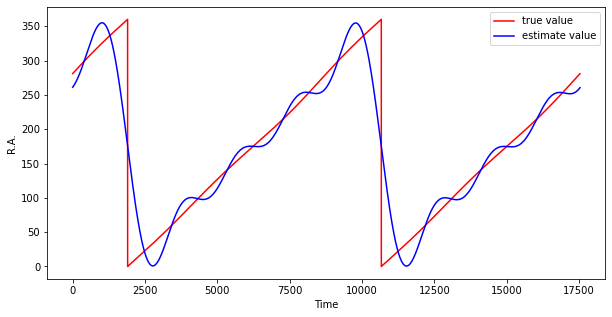

In [293]:
col = 'R.A.'
#n_harm = 80 # for moon
n_harm = 4 # for sun
restored_val = fourierExtrapolation(data_train[col], 0, n_harm)
train_loss = np.mean((data_train[col]- restored_val))**2
restored_val = fourierExtrapolation(data_train[col], N_validation, n_harm)
val_loss = np.mean((data_validation[col]- restored_val[-N_validation:]))**2
restored_test = fourierExtrapolation(data_train[col], N_validation + N_test, n_harm)
test_loss = np.mean((data_test[col]- restored_test[-N_test:]))**2
print("train_error:", train_loss)
print("validation_error:", val_loss)
print("test_error:", test_loss)
plt.figure(figsize=(10,5))
plt.ylabel("R.A.")
plt.xlabel("Time")
plt.plot(list(data_test[col]), 'r-', label = 'true value')
plt.plot(restored_test[-N_test:], 'b-', label = 'estimate value')
plt.legend()
#plt.plot(data[col], 'r-')
#plt.plot(restored_test, 'b-')

n_harm for DEC: 1


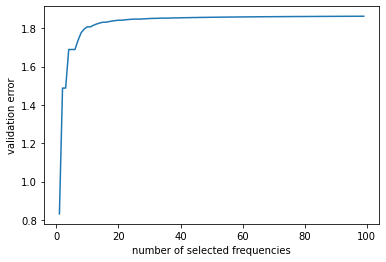

In [294]:
DEC_loss = tune_n_harm('DEC', [i for i in range(1, 100) ])
print("n_harm for DEC:", (np.argmin(DEC_loss)+1))

train_error: 4.427222843156074e-31
validation_error: 0.8307041386918037
test_error: 1.867953298531402


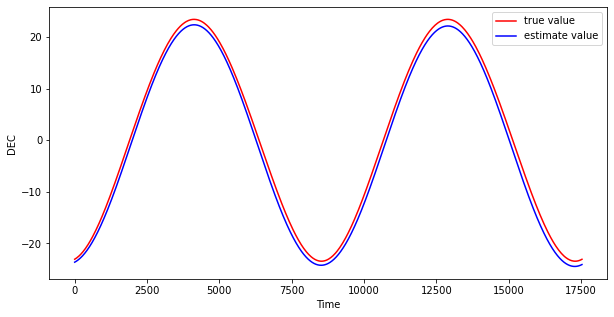

In [295]:
col = 'DEC'
# n_harm = 6 # for moon
n_harm = 1 # for sun
restored_val = fourierExtrapolation(data_train[col], 0, n_harm)
train_loss = np.mean((data_train[col]- restored_val))**2
restored_val = fourierExtrapolation(data_train[col], N_validation, n_harm)
val_loss = np.mean((data_validation[col]- restored_val[-N_validation:]))**2
restored_test = fourierExtrapolation(data_train[col], N_validation + N_test, n_harm)
test_loss = np.mean((data_test[col]- restored_test[-N_test:]))**2
print("train_error:", train_loss)
print("validation_error:", val_loss)
print("test_error:", test_loss)
plt.figure(figsize=(10,5))
plt.ylabel("DEC")
plt.xlabel("Time")
plt.plot(list(data_test[col]), 'r', label='true value')
plt.plot(restored_test[-N_test:], 'b', label='estimate value')
plt.legend()
#plt.plot(data[col], 'r-')
#plt.plot(restored_test, 'b-')